# Pendulum Environment, OpenAI Gym
* Left force: -50N, Right force: 50N, Nothing: 0N, with some amount of noise added to the action
* Generate trajectories by starting upright, and then applying random forces. 
* Failure if the pendulum exceeds +/- pi/2
* Setting this problem up: how to encode Newtons? I'm starting things upright- how do we determine success? 

In [1]:
import configargparse
import torch
import torch.optim as optim
import sys
sys.path.append('../')

from environments import PendulumEnv
from models.agents import NFQAgent
from models.networks import NFQNetwork, ContrastiveNFQNetwork
from util import get_logger, close_logger, load_models, make_reproducible, save_models
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
import tqdm

/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

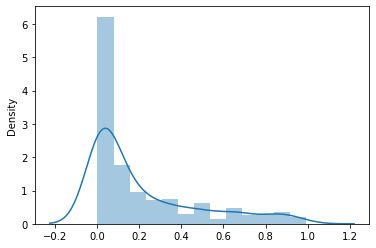

In [2]:
env = PendulumEnv()
rollouts = []
for i in range(10):
    rollout, episode_cost = env.generate_rollout()
    rollouts.extend(rollout)
rewards = [r[2] for r in rollouts]
sns.distplot(rewards)

In [3]:
def generate_data(init_experience=100, bg_only=False, agent=None):
    env_bg = PendulumEnv(group=0)
    env_fg = PendulumEnv(group=1)
    bg_rollouts = []
    fg_rollouts = []
    if init_experience > 0:
        for _ in range(init_experience):
            rollout_bg, episode_cost = env_bg.generate_rollout(
                agent, render=False, group=0
            )
            bg_rollouts.extend(rollout_bg)
            if not bg_only:
                rollout_fg, episode_cost = env_fg.generate_rollout(
                    agent, render=False, group=1
                )
                fg_rollouts.extend(rollout_fg)
    bg_rollouts.extend(fg_rollouts)
    all_rollouts = bg_rollouts.copy()
    return all_rollouts, env_bg, env_fg

In [5]:
train_rollouts, train_env_bg, train_env_fg = generate_data(init_experience=200, bg_only=True)
test_rollouts, eval_env_bg, eval_env_fg = generate_data(init_experience=200, bg_only=True)

is_contrastive=True
epoch = 1000
hint_to_goal = False
if hint_to_goal:
    goal_state_action_b_bg, goal_target_q_values_bg, group_bg = train_env_bg.get_goal_pattern_set(group=0)
    goal_state_action_b_fg, goal_target_q_values_fg, group_fg = train_env_fg.get_goal_pattern_set(group=1)
    
    goal_state_action_b_bg = torch.FloatTensor(goal_state_action_b_bg)
    goal_target_q_values_bg = torch.FloatTensor(goal_target_q_values_bg)
    goal_state_action_b_fg = torch.FloatTensor(goal_state_action_b_fg)
    goal_target_q_values_fg = torch.FloatTensor(goal_target_q_values_fg)
    
nfq_net = ContrastiveNFQNetwork(state_dim=train_env_bg.state_dim, is_contrastive=is_contrastive, deep=False)
optimizer = optim.Adam(nfq_net.parameters(), lr=1e-1)

nfq_agent = NFQAgent(nfq_net, optimizer)

bg_success_queue = [0] * 3
fg_success_queue = [0] * 3
eval_fg = 0
evaluations = 5
for k, ep in enumerate(tqdm.tqdm(range(epoch + 1))):
    state_action_b, target_q_values, groups = nfq_agent.generate_pattern_set(train_rollouts)
    if hint_to_goal:
        goal_state_action_b = torch.cat([goal_state_action_b_bg, goal_state_action_b_fg], dim=0)
        goal_target_q_values = torch.cat([goal_target_q_values_bg, goal_target_q_values_fg], dim=0)
        state_action_b = torch.cat([state_action_b, goal_state_action_b], dim=0)
        target_q_values = torch.cat([target_q_values, goal_target_q_values], dim=0)
        goal_groups = torch.cat([group_bg, group_fg], dim=0)
        groups = torch.cat([groups, goal_groups], dim=0)

    if not nfq_net.freeze_shared:
        loss = nfq_agent.train((state_action_b, target_q_values, groups))

    eval_episode_length_fg, eval_success_fg, eval_episode_cost_fg = 0, 0, 0
    if nfq_net.freeze_shared:
        eval_fg += 1
        if eval_fg > 50:
            loss = nfq_agent.train((state_action_b, target_q_values, groups))

    (eval_episode_length_bg, eval_success_bg, eval_episode_cost_bg) = nfq_agent.evaluate_pendulum(eval_env_bg, render=False)
    bg_success_queue = bg_success_queue[1:]
    bg_success_queue.append(1 if eval_success_bg else 0)
    
    (eval_episode_length_fg, eval_success_fg, eval_episode_cost_fg) = nfq_agent.evaluate_pendulum(eval_env_fg, render=False)
    fg_success_queue = fg_success_queue[1:]
    fg_success_queue.append(1 if eval_success_fg else 0)

    if sum(bg_success_queue) == 3 and not nfq_net.freeze_shared == True:
        nfq_net.freeze_shared = True
        print("FREEZING SHARED")
        if is_contrastive:
            for param in nfq_net.layers_shared.parameters():
                param.requires_grad = False
            for param in nfq_net.layers_last_shared.parameters():
                param.requires_grad = False
            for param in nfq_net.layers_fg.parameters():
                param.requires_grad = True
            for param in nfq_net.layers_last_fg.parameters():
                param.requires_grad = True
        else:
            for param in nfq_net.layers_fg.parameters():
                param.requires_grad = False
            for param in nfq_net.layers_last_fg.parameters():
                param.requires_grad = False

        optimizer = optim.Adam(
            itertools.chain(
                nfq_net.layers_fg.parameters(),
                nfq_net.layers_last_fg.parameters(),
            ),
            lr=1e-1,
        )
        nfq_agent._optimizer = optimizer
    if sum(fg_success_queue) == 3:
        print("Done Training")
        break
    if ep % 300 == 0:
        perf_bg = []
        perf_fg = []
        for it in range(evaluations):
            (eval_episode_length_bg,eval_success_bg,eval_episode_cost_bg) = nfq_agent.evaluate_pendulum(eval_env_bg, render=False)
            (eval_episode_length_fg,eval_success_fg,eval_episode_cost_fg) = nfq_agent.evaluate_pendulum(eval_env_fg, render=False)
            perf_bg.append(eval_episode_cost_bg)
            perf_fg.append(eval_episode_cost_fg)
            train_env_bg.close()
            train_env_fg.close()
            eval_env_bg.close()
            eval_env_fg.close()
        print("Evaluation bg: " + str(perf_bg) + " Evaluation fg: " + str(perf_fg))
perf_bg = []
perf_fg = []
for it in range(evaluations*10):
    (eval_episode_length_bg,eval_success_bg,eval_episode_cost_bg) = nfq_agent.evaluate_car(eval_env_bg, render=False)
    (eval_episode_length_fg,eval_success_fg,eval_episode_cost_fg) = nfq_agent.evaluate_car(eval_env_fg, render=False)
    perf_bg.append(eval_episode_cost_bg)
    perf_fg.append(eval_episode_cost_fg)
    eval_env_bg.close()
    eval_env_fg.close()
print("Evaluation bg: " + str(sum(perf_bg)/len(perf_bg)) + " Evaluation fg: " + str(sum(perf_fg)/len(perf_fg)))

  0%|          | 1/1001 [00:01<22:02,  1.32s/it]

Evaluation bg: [73.81142197848965, 72.28765194473992, 73.73941817745897, 73.48222940956178, 73.49007680694399] Evaluation fg: [74.01250678450806, 73.65066927176343, 74.84724716461659, 73.11356339568685, 75.0214335207005]


 30%|███       | 301/1001 [01:17<06:24,  1.82it/s]

Evaluation bg: [25.91933239636995, 25.943631812838813, 25.918313560945293, 25.93831096791118, 25.91540663172479] Evaluation fg: [25.96212970651441, 25.909092804253845, 25.90101909324823, 25.93344660781633, 25.913366980623046]


 60%|██████    | 601/1001 [02:33<03:46,  1.77it/s]

Evaluation bg: [25.930066512891948, 25.919891857887908, 25.920398622003734, 25.98697165556666, 25.919573906670177] Evaluation fg: [25.91221921137715, 25.935719469985738, 25.930626828078918, 25.91169053116927, 25.9646164792548]


 90%|█████████ | 901/1001 [03:50<00:55,  1.81it/s]

Evaluation bg: [25.971403504800346, 25.982871052864095, 25.90971079444938, 25.962789946549336, 25.91520164596239] Evaluation fg: [25.941113174043924, 25.9494665088202, 25.936848622450885, 25.93515375752261, 25.946367689179176]


100%|██████████| 1001/1001 [04:15<00:00,  3.92it/s]


Evaluation bg: 25.94022201048524 Evaluation fg: 25.939652176939322
